In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # Ignore User Warning regarding Shapely
import matplotlib.pyplot as plt
import contextily
import pandas as pd
import geopandas as gpd
import pymssql
from shapely import wkb
import matplotlib.pyplot as plt
from tobler.area_weighted import area_interpolate
import os

# Rasterio Installation bug where the Environment variable 'PROJ_LIB' isn't looking in the right file for 'Proj.db' SQLlite Database
# After installation, you need to find the folder where rasterio is storing the 'Proj.db' file and set the environment variable 'PROJ_LIB' to use the right file path
os.environ['PROJ_LIB'] = '/Users/ahadhussain/opt/anaconda3/lib/python3.9/site-packages/rasterio/proj_data/'

In [2]:
database = 'Pushing-P-DB'
table1 = 'dbo.NJ_Cities'
table2 = 'dbo.NJ_Census_Tracts'
user = 'pushing_p'
password  = 't3stP@ssword'
server = 'gen10-data-fundamentals-22-02-sql-server.database.windows.net'


# Retrieve Training Data for Geographically Weighted Regression Model
conn = pymssql.connect(server, user, password, database)

# Query select all rows from SQL tables to insert into their respective DataFrames
query1 = f'SELECT * FROM {table1}'
query2 = f'SELECT * FROM {table2}'
df = pd.read_sql(query1, conn)
tract_info = pd.read_sql(query2, conn)

# Use a function to convert wkb_hex string in SQL database to polygonal geometries (WKB stands for Well-Known Binary, which is commonly used for encoding geographic polygons)
# WKT, well-known text, markup can also be used

def convert_to_polygon(hex):
    return wkb.loads(hex, hex=True)
df['geometry'] = df['geometry'].apply(convert_to_polygon)
tract_info['geometry'] = tract_info['geometry'].apply(convert_to_polygon)

# Convert from pandas to geopandas dataframes
df = gpd.GeoDataFrame(df, geometry=df['geometry'], crs = 'epsg:4269')
tract_info = gpd.GeoDataFrame(tract_info, geometry=tract_info['geometry'], crs = 'epsg:4269')

# Add % Uninsured Column
df['% Uninsured'] = df['Uninsured Population']/df['City Population']*100
tract_info['% Uninsured'] = tract_info['Uninsured Population']/tract_info['City Population']*100


In [3]:
df.head()

,State,County,City,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population","NUI, Other Races",geometry,% Uninsured
0,New Jersey,Camden County,Brooklawn Borough,6.3,44805,1888,95,0,15,18,...,49,46,87,0,0,0,0,0,"POLYGON ((-75.13175 39.87852, -75.12834 39.879...",5.031780
1,New Jersey,Middlesex County,Metuchen Borough,4.4,136067,14289,300,0,10,50,...,187,113,65,58,0,157,0,20,"POLYGON ((-74.38258 40.55220, -74.38032 40.552...",2.099517
2,New Jersey,Morris County,Rockaway Borough,9.9,86442,6345,375,20,25,6,...,199,176,276,0,0,87,0,12,"POLYGON ((-74.53641 40.89071, -74.52470 40.901...",5.910165
3,New Jersey,Burlington County,Bass River Township,11.9,71618,1225,104,0,0,21,...,75,29,104,0,0,0,0,0,"POLYGON ((-74.52831 39.65573, -74.52710 39.656...",8.489796
4,New Jersey,Hunterdon County,Lambertville,3.6,105744,3809,156,0,0,27,...,111,45,156,0,0,0,0,0,"POLYGON ((-74.95426 40.37655, -74.95068 40.377...",4.095563


In [4]:
tract_info.head()

,Census Tract,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years","NUI, 26 to 34 years","NUI, 35 to 44 years","NUI, 45 to 54 years","NUI, 55 to 64 years","NUI, 65 years and older","NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population",geometry,% Uninsured
0,"Census Tract 101.01, Atlantic County, New Jersey",3270.0,82.0,0.0,0.0,0.0,67.0,0.0,6.0,9.0,0.0,73.0,9.0,81.0,1.0,0.0,0.0,0.0,"POLYGON ((-74.40783 39.40556, -74.40551 39.407...",2.507645
1,"Census Tract 47, Middlesex County, New Jersey",3716.0,678.0,0.0,30.0,105.0,327.0,44.0,139.0,33.0,0.0,312.0,366.0,449.0,38.0,0.0,0.0,0.0,"POLYGON ((-74.29005 40.52265, -74.28748 40.521...",18.245425
2,"Census Tract 74, Hudson County, New Jersey",4972.0,8.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-74.04147 40.71347, -74.03645 40.712...",0.160901
3,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-74.06749 40.71857, -74.06673 40.720...",NaN
4,"Census Tract 104.01, Cumberland County, New Je...",4916.0,582.0,56.0,14.0,88.0,133.0,100.0,115.0,70.0,6.0,357.0,225.0,222.0,230.0,10.0,4.0,0.0,"POLYGON ((-75.36562 39.35723, -75.36416 39.358...",11.838893


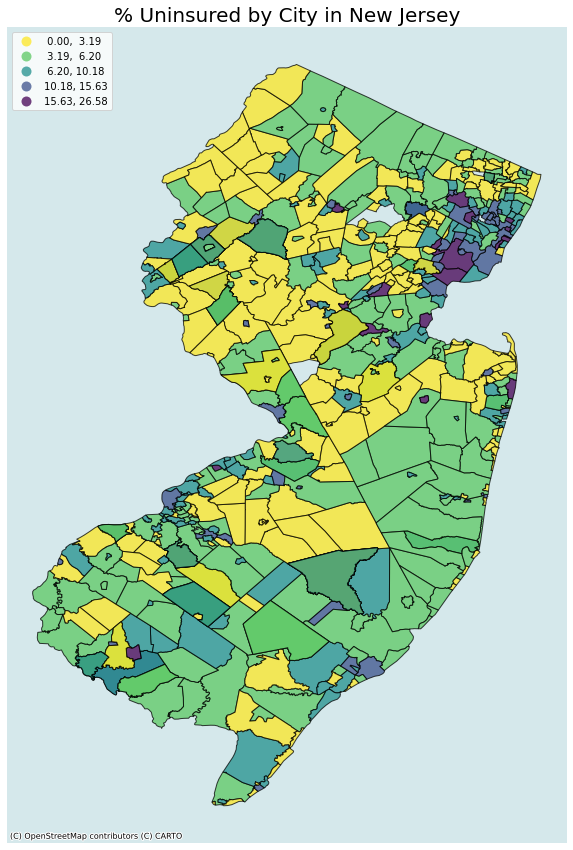

In [5]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(15, 15))

# Build choropleth
df.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme='natural_breaks',
    k=5, 
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Voyager,
)

plt.title('% Uninsured by City in New Jersey', fontsize=20)
ax.set_axis_off();

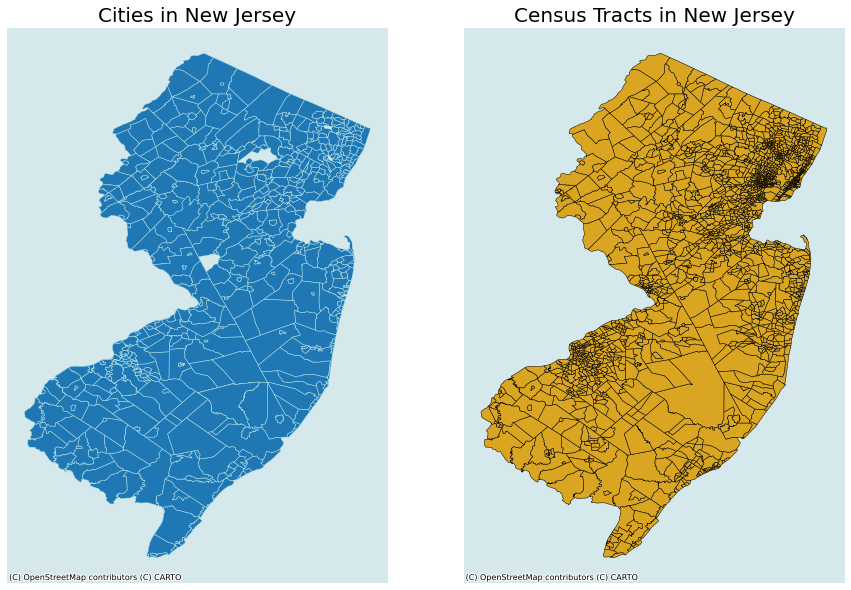

In [6]:
fig, ax = plt.subplots(1,2, figsize=(15,20))

df.plot(ax=ax[0], edgecolor = 'powderblue', linewidth = 0.5)
tract_info.plot(ax=ax[1], color = 'goldenrod',edgecolor = 'black', linewidth = 0.5)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)
ax[0].set_title('Cities in New Jersey', fontsize=20)
ax[1].set_title('Census Tracts in New Jersey', fontsize=20)
ax[0].axis('off')
ax[1].axis('off');


#### Areal Interpolation:
- Areal interpolation is the process making estimates from a source set of polygons to an overlapping but incongruent set of target polygons. 

- The simplest technique available in `tobler` is **simple areal interpolation** in which variables from the source data are weighted according to the overlap between source and target polygons, then reaggregated to fit the target polygon geometries

In [7]:
# Drop rows with null values (about 175 counties are missing healthcare information so we drop those from our analysis)
tract_info.dropna(inplace=True)
tract_info.shape

(1821, 20)

In [8]:
extensive_variables = list(df.drop(['State','County','City','geometry','Unemployment Rate (16 & Over)', '% Uninsured'], axis=1).columns)
results = area_interpolate(source_df=df, target_df=tract_info, intensive_variables = ['Unemployment Rate (16 & Over)'], extensive_variables=extensive_variables)

In [9]:
results.head()

,Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years","NUI, 26 to 34 years","NUI, 35 to 44 years","NUI, 45 to 54 years","NUI, 55 to 64 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population","NUI, Other Races",Unemployment Rate (16 & Over),geometry
0,54154.603670,6243.714013,231.488303,7.907986,12.940340,23.723957,93.458011,44.572282,18.691602,30.194126,...,124.371045,107.117258,192.667283,0.718908,0.000000,12.221432,0.0,14.378155,5.9,"POLYGON ((-74.40783 39.40556, -74.40551 39.407..."
1,3490.776007,3296.164020,653.216002,23.770878,81.233272,111.574962,143.398306,116.535281,112.090320,51.406940,...,338.718909,314.497093,439.020419,24.737174,1.159555,3.478665,0.0,129.161547,6.7,"POLYGON ((-74.29005 40.52265, -74.28748 40.521..."
2,1781.081944,6092.337528,634.669459,15.820138,42.218101,84.203209,175.699060,118.872378,97.227447,79.030793,...,352.539779,282.129680,186.183688,164.142670,8.108112,117.893813,0.0,118.639386,5.3,"POLYGON ((-74.04147 40.71347, -74.03645 40.712..."
3,150531.000000,12479.000000,1069.000000,56.000000,14.000000,88.000000,184.000000,113.000000,501.000000,107.000000,...,525.000000,544.000000,574.000000,230.000000,10.000000,139.000000,0.0,87.000000,9.7,"POLYGON ((-75.36562 39.35723, -75.36416 39.358..."
4,10077.419059,2073.954595,78.260895,2.535097,2.616874,4.088866,14.065699,18.072788,25.923410,9.731501,...,40.888660,37.372235,61.414767,4.007089,0.000000,7.687068,0.0,4.579530,4.9,"POLYGON ((-74.54252 40.92796, -74.54081 40.930..."


In [10]:
# Create Uninsurance rate columns

results['% Uninsured'] = results['Uninsured Population']/results['City Population']*100
results['% African'] = results['NUI, African American']/results['Uninsured Population']*100
tract_info['% African'] = tract_info['NUI, African American']/tract_info['Uninsured Population']*100
results['% White'] = results['NUI, White']/results['Uninsured Population']*100
tract_info['% White'] = tract_info['NUI, White']/tract_info['Uninsured Population']*100

results.shape

(1821, 24)

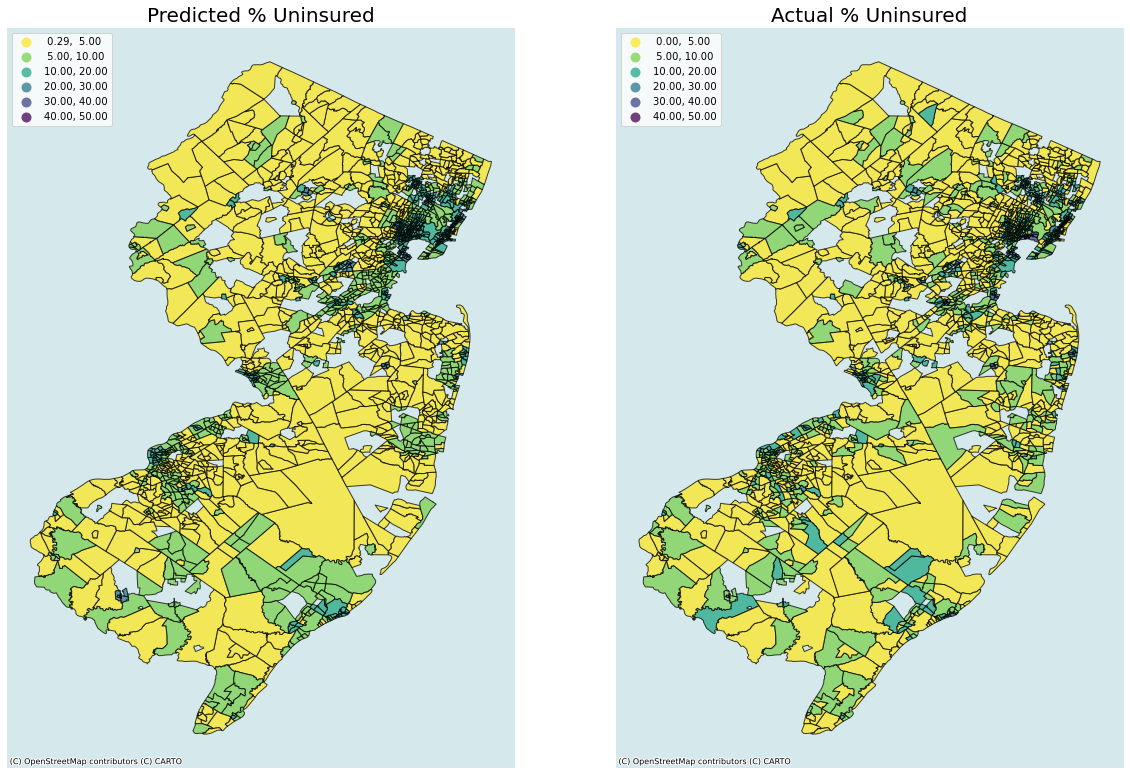

In [11]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured',fontsize=20)
ax[1].set_title('Actual % Uninsured',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

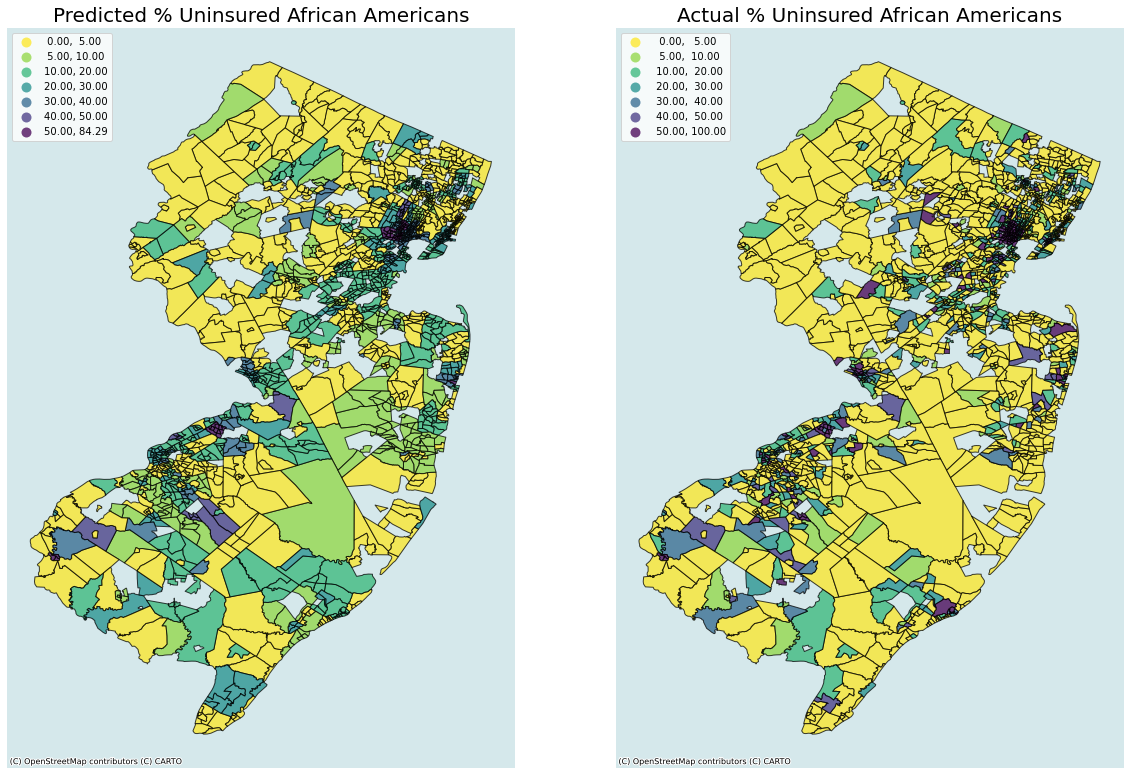

In [12]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% African', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% African', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured African Americans',fontsize=20)
ax[1].set_title('Actual % Uninsured African Americans',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

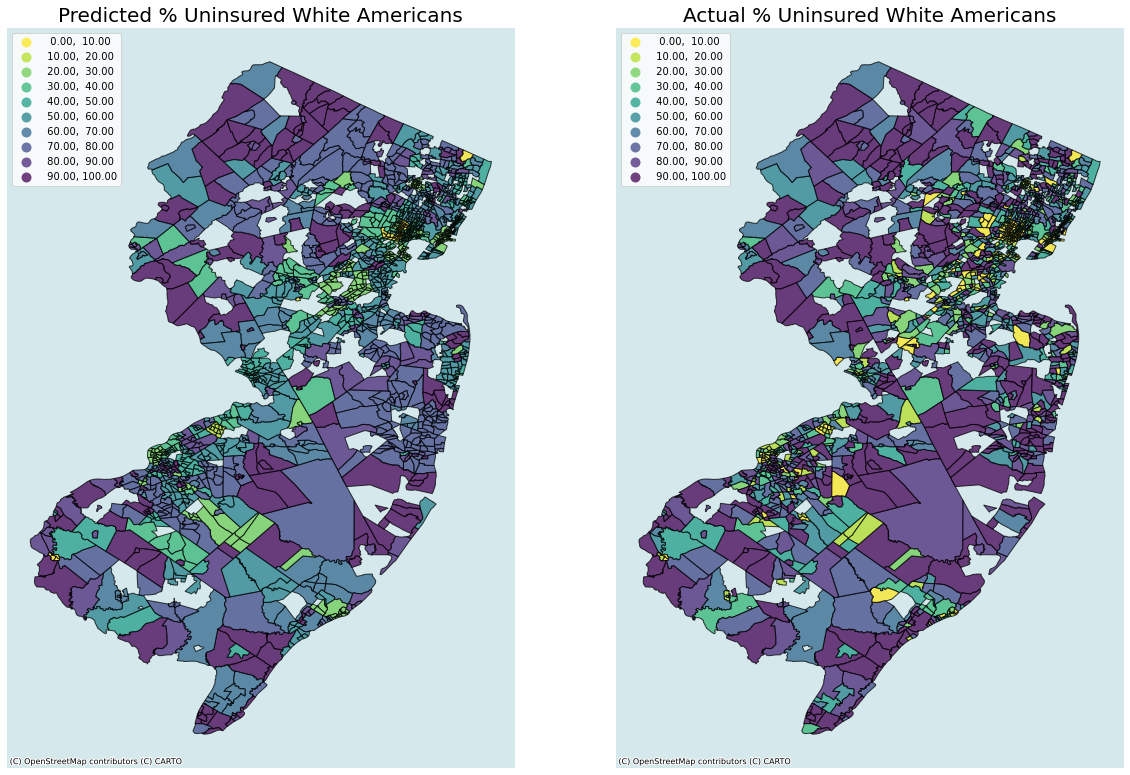

In [13]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% White', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[10,20,30,40,50,60,70,80,90,100]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% White', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[10,20,30,40,50,60,70,80,90,100]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured White Americans',fontsize=20)
ax[1].set_title('Actual % Uninsured White Americans',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

In [14]:
# Export Model using joblib

from joblib import dump, load
dump(results, 'areal interpolation joblib.model')

['areal interpolation joblib.model']